In [132]:
import numpy as np
import pandas as pd

In [133]:
train = pd.read_csv("../../../train-metadata.csv")
test = pd.read_csv("../../../test-metadata.csv")

C:\Users\efim6\AppData\Local\Temp\ipykernel_21436\1523111444.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../../../train-metadata.csv")


In [134]:
train.shape

(401059, 55)

In [135]:
y = train["target"]

In [136]:
test.shape

(3, 44)

Test has fewer columns than train - only use the intersection so that we can apply to test data <br>

In [137]:
shared_cols = set(train.columns).intersection(set(test.columns))
len(shared_cols)

44

Use second line in the next cell if you want to use all columns instead.

In [138]:
# train_trim = train[list(shared_cols)]
train_trim = train.drop("target", axis=1)
train_trim.shape

(401059, 54)

String columns

In [139]:
len(train_trim.select_dtypes(include="object").columns)

18

Number columns

In [140]:
len(train_trim.select_dtypes(include="number").columns)

36

Null checking

In [141]:
nulls = train_trim.apply(lambda col: col.isnull().sum() / col.size * 100)
nulls.head()

isic_id                0.000000
patient_id             0.000000
age_approx             0.697653
sex                    2.871647
anatom_site_general    1.435200
dtype: float64

Columns with nulls

In [142]:
nulls[nulls > 0]

age_approx              0.697653
sex                     2.871647
anatom_site_general     1.435200
lesion_id              94.500061
iddx_2                 99.733705
iddx_3                 99.734453
iddx_4                 99.862614
iddx_5                 99.999751
mel_mitotic_index      99.986785
mel_thick_mm           99.984292
dtype: float64

Dropping rows with null age. Sex handled later, anatom_site_general not used.

In [143]:
train_trim = train_trim.dropna(subset=['age_approx'])

Extract string columns

In [144]:
string_cols = train_trim.select_dtypes(include="object")
string_cols.head()

,isic_id,patient_id,sex,anatom_site_general,image_type,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index
0,ISIC_0015670,IP_1235828,male,lower extremity,TBP tile: close-up,3D: white,Right Leg - Upper,Right Leg,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN
1,ISIC_0015845,IP_8170065,male,head/neck,TBP tile: close-up,3D: white,Head & Neck,Head & Neck,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN
2,ISIC_0015864,IP_6724798,male,posterior torso,TBP tile: close-up,3D: XP,Torso Back Top Third,Torso Back,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN
3,ISIC_0015902,IP_4111386,male,anterior torso,TBP tile: close-up,3D: XP,Torso Front Top Half,Torso Front,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN
4,ISIC_0024200,IP_8313778,male,anterior torso,TBP tile: close-up,3D: white,Torso Front Top Half,Torso Front,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN


Check for constant-value columns

In [145]:
string_cols.apply(lambda row: row.unique())

isic_id                   [ISIC_0015670, ISIC_0015845, ISIC_0015864, ISI...
patient_id                [IP_1235828, IP_8170065, IP_6724798, IP_411138...
sex                                                     [male, female, nan]
anatom_site_general       [lower extremity, head/neck, posterior torso, ...
image_type                                             [TBP tile: close-up]
tbp_tile_type                                           [3D: white, 3D: XP]
tbp_lv_location           [Right Leg - Upper, Head & Neck, Torso Back To...
tbp_lv_location_simple    [Right Leg, Head & Neck, Torso Back, Torso Fro...
attribution               [Memorial Sloan Kettering Cancer Center, ACEMI...
copyright_license                                   [CC-BY, CC-0, CC-BY-NC]
lesion_id                 [nan, IL_6727506, IL_3854228, IL_9898853, IL_2...
iddx_full                 [Benign, Benign::Benign epidermal proliferatio...
iddx_1                                   [Benign, Malignant, Indeterminate]
iddx_2      

Drop ID and other useless string columns

In [146]:
to_drop = ["tbp_tile_type", "copyright_license", "isic_id", "patient_id", "attribution", "image_type"]
set(string_cols.columns).difference(set(to_drop))

{'anatom_site_general',
 'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'iddx_full',
 'lesion_id',
 'mel_mitotic_index',
 'sex',
 'tbp_lv_location',
 'tbp_lv_location_simple'}

3 location columns, increasing specificity. Using the middle one for one-hot encoding

In [147]:
string_cols["anatom_site_general"].value_counts()

anatom_site_general
posterior torso    121143
lower extremity    102071
anterior torso      87256
upper extremity     70088
head/neck           11962
Name: count, dtype: int64

In [148]:
string_cols["tbp_lv_location_simple"].value_counts()

tbp_lv_location_simple
Torso Back     121143
Torso Front     87256
Left Leg        52633
Right Leg       49438
Left Arm        36124
Right Arm       33964
Head & Neck     11962
Unknown          5741
Name: count, dtype: int64

In [149]:
string_cols["tbp_lv_location"].value_counts()

tbp_lv_location
Torso Back Top Third       70703
Torso Front Top Half       62991
Torso Back Middle Third    45859
Left Leg - Lower           27205
Right Leg - Lower          25008
Torso Front Bottom Half    24205
Left Leg - Upper           23454
Right Arm - Upper          22849
Right Leg - Upper          22719
Left Arm - Upper           22713
Head & Neck                11962
Left Arm - Lower           11820
Right Arm - Lower          10514
Unknown                     5741
Torso Back Bottom Third     4572
Left Leg                    1974
Right Leg                   1711
Left Arm                    1591
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: count, dtype: int64

One-hot encoding the sex column. Using a vector of length 2 here to account for the NaaNs - when the value is "unknown", the vector is [0, 0]. Alternatively, we could drop all NaaN rows and use a single indicator column.

In [150]:
male_indicator = string_cols["sex"].apply(lambda s: int(s == "male" and not s == "unknown"))
male_indicator.name = "Male"
female_indicator = string_cols["sex"].apply(lambda s: int(s == "female" and not s == "unknown"))
female_indicator.name = "Female"

In [151]:
numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
numerical_sex.tail()

,Male,Female
401054,1,0
401055,1,0
401056,0,1
401057,0,1
401058,1,0


One-hot encoding the location column

In [152]:
one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: int(loc == location))).transpose()
one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
one_hot_location.head()


tbp_lv_location_simple,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


Total one-hot encoded columns

In [153]:
one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
one_hot_combined.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0


Normalizing other numerical columns to the [0, 1] range with min-max scaling

In [154]:
numerical = train_trim.select_dtypes(include="number")

for column in numerical.columns: 
    numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())     

Concat with numerical columns to get the clean data

In [155]:
clean = pd.concat([one_hot_combined, numerical], axis=1)
clean.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,age_approx,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,1,0,0,0,0,1,0,0,0,0.6875,...,0.000000,0.102225,0.080388,0.582086,0.485714,0.356776,0.566559,0.408087,NaN,0.975173
1,1,0,0,0,0,0,0,0,1,0.6875,...,0.000000,0.033828,0.131598,0.252621,0.314286,0.504132,0.893847,0.571023,NaN,0.031415
2,1,0,1,0,0,0,0,0,0,0.6875,...,0.000000,0.085311,0.052795,0.334987,0.600000,0.603966,0.858581,0.858501,NaN,0.998040
3,1,0,0,1,0,0,0,0,0,0.7500,...,0.057844,0.057262,0.037652,0.170317,0.742857,0.390405,0.848437,0.572962,NaN,0.999900
4,1,0,0,1,0,0,0,0,0,0.6250,...,0.000000,0.105071,0.074071,0.282586,0.114286,0.445845,0.864265,0.512548,NaN,0.704425


In [156]:
clean.columns

Index(['Male', 'Female', 'Torso Back', 'Torso Front', 'Left Leg', 'Right Leg',
       'Left Arm', 'Right Arm', 'Head & Neck', 'age_approx',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
       'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')

Save the clean data

In [157]:
# clean.to_csv("../../../clean_train-metadata.csv", index=False)

In [158]:
y = y[clean.index]

In [159]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 60, 20, 20 - train, test, validation
X_train, X_test, y_train, y_test = train_test_split(clean, y, test_size=0.2,random_state=42)

In [160]:
num_parallel_tree = 4
num_boost_round = 16
# total number of built trees is num_parallel_tree * num_classes * num_boost_round

dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain)

In [161]:
dtest = xgb.DMatrix(X_test)
y_pred = booster.predict(dtest)
y_test = y_test.to_numpy()

In [162]:
np.mean(y_pred == y_test)

np.float64(0.9991965148833063)

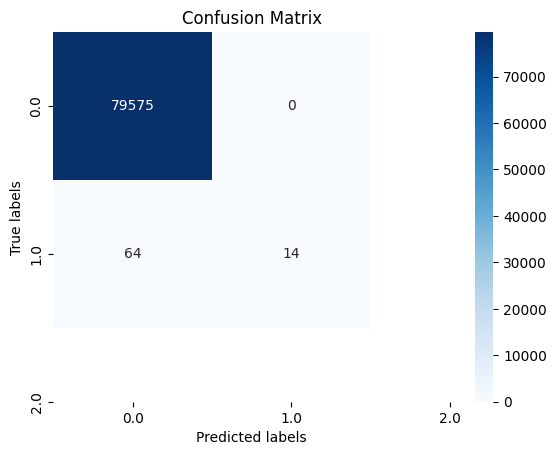

In [163]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [164]:
y

0         0
1         0
2         0
3         0
4         0
         ..
401054    0
401055    0
401056    0
401057    0
401058    0
Name: target, Length: 398261, dtype: int64

In [165]:
df = pd.concat([clean, y], axis=1)
df.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,age_approx,...,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence,target
0,1,0,0,0,0,1,0,0,0,0.6875,...,0.102225,0.080388,0.582086,0.485714,0.356776,0.566559,0.408087,NaN,0.975173,0
1,1,0,0,0,0,0,0,0,1,0.6875,...,0.033828,0.131598,0.252621,0.314286,0.504132,0.893847,0.571023,NaN,0.031415,0
2,1,0,1,0,0,0,0,0,0,0.6875,...,0.085311,0.052795,0.334987,0.600000,0.603966,0.858581,0.858501,NaN,0.998040,0
3,1,0,0,1,0,0,0,0,0,0.7500,...,0.057262,0.037652,0.170317,0.742857,0.390405,0.848437,0.572962,NaN,0.999900,0
4,1,0,0,1,0,0,0,0,0,0.6250,...,0.105071,0.074071,0.282586,0.114286,0.445845,0.864265,0.512548,NaN,0.704425,0


In [166]:
from sklearn.utils.class_weight import compute_class_weight
#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1
neg_sample = .01
pos_sample = 5.0
# Sampling
positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=True, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902074
1     0.097926
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    67.110811
1    32.889189
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.7450364413169138), 1: np.float64(1.5202564102564102)}


In [167]:
x = df.drop("target", axis=1)
y = df["target"]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [169]:
num_parallel_tree = 4
num_boost_round = 16
# total number of built trees is num_parallel_tree * num_classes * num_boost_round

dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain)

In [170]:
dtest = xgb.DMatrix(X_test)
y_pred = booster.predict(dtest)
y_test = y_test.to_numpy()

In [171]:
np.mean(y_pred == y_test)

np.float64(0.9763912310286678)

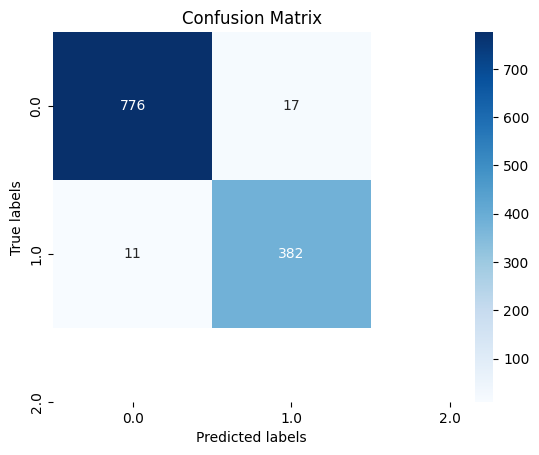

In [172]:
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()